# data loading and initial filtering

In [1]:
import math
from data_loader import Data_loader
from pair_filter import NPD_filter
from pair_filter import OLS_filter
import matplotlib.pyplot as plt



# loading data
start_idx = 0
window_length = math.floor(252* (6/12 + 2/12)) # 6 month training, 2 month testing
train_ratio = 6/8

dl = Data_loader(train_ratio=train_ratio, window_length=window_length)
window_train, window_test = dl.get_window(start_idx=start_idx)



# NPD selection
NPD = NPD_filter(window_train)
pairs, distance = NPD.select_pairs(percentile=5, verbose=True)


# OLS selection
OLS = OLS_filter(window_train)
pairs, params = OLS.select_pairs(pairs, verbose=True, confidence_level=0.05)

35790 pairs selected
min distance 0.0
max distance 0.4082340738360386
14086 out of 35790 pairs passed the test
pass rate: 0.39


# select top-k pairs accorindg to train sharpe ratio

In [2]:
from backtest import *

top_k = 50

bt = PairTradingBacktester_TrainTest(pairs[:300], params[:300], window_train, window_test) # for testing purpose
# bt = PairTradingBacktester_TrainTest(pairs, params, window_train, window_test) # complete
summary = bt.run(top_k=top_k)


spreads_train  = bt.train_spreads_df
spreads_test  = bt.test_spreads_df
returns_test   = bt.test_returns_df
returns_train   = bt.train_returns_df
comp_weights=bt.comp_weights

Train back-test:   0%|          | 0/300 [00:00<?, ?it/s]

Test back-test:   0%|          | 0/50 [00:00<?, ?it/s]

# MRP optimizer

In [3]:
from optimizers import MRP_optimizer_scipy

optimal_weights=MRP_optimizer_scipy(spreads_data=spreads_train)
weights_by_levels=pd.concat([comp_weights.reset_index(level=1),optimal_weights],axis=1) # different levels of weights, combined by pair index

weights_by_levels['flat_w']=weights_by_levels['component_w']*weights_by_levels['opt_w']
weights_single_stocks=weights_by_levels.groupby('stock')['flat_w'].sum()

(CVXPY) May 09 06:15:25 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError("dlopen(/Users/keyangpan/anaconda3/lib/python3.11/site-packages/cvxopt/base.cpython-311-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <E25E40AB-7857-39B9-8DE7-28B7B0E4806B> /Users/keyangpan/anaconda3/lib/python3.11/site-packages/cvxopt/base.cpython-311-darwin.so\n  Reason: tried: '/Users/keyangpan/anaconda3/lib/python3.11/site-packages/cvxopt/../../../liblapack.3.dylib' (no such file), '/Users/keyangpan/anaconda3/lib/python3.11/site-packages/cvxopt/../../../liblapack.3.dylib' (no such file), '/Users/keyangpan/anaconda3/bin/../lib/liblapack.3.dylib' (no such file), '/Users/keyangpan/anaconda3/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)")
(CVXPY) May 09 06:15:25 PM: Encountered unexpected exception importing solver GLPK:
ImportError("dlope

# forming new portfolio and backtest

In [15]:
from backtest_MRP import backtest_MRP

bt_MRP = backtest_MRP(weights_single_stocks, window_train, window_test)

pnl_train, pnl_test = bt_MRP.run()



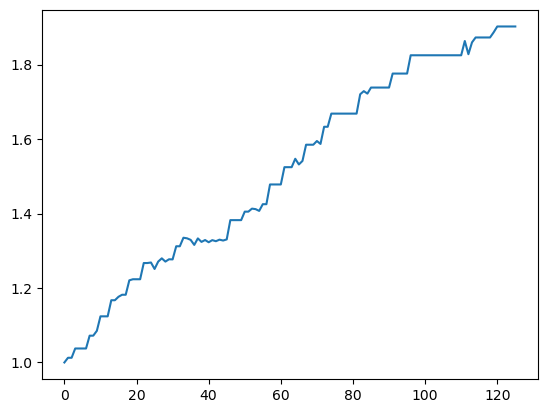

In [17]:
plt.plot(pnl_train)

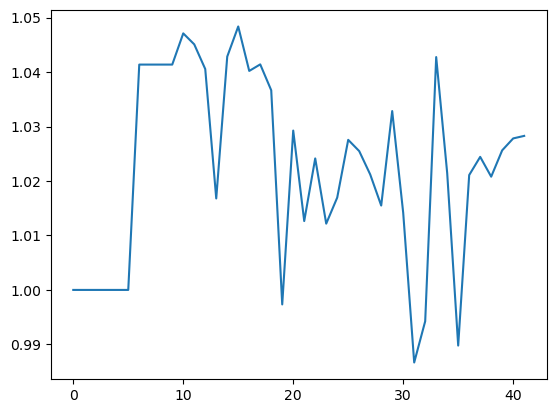

In [18]:
plt.plot(pnl_test)